In [709]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import itertools

from pathlib import Path

In [ ]:
expt_path = Path('/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206')
img_data_json_name = 'image_metadata_SU000001.json'

img_data = pd.read_json(Path(expt_path, img_data_json_name))
img_data = img_data.T.reset_index(drop=True)
img_data.columns = img_data.columns.str.replace(' ', '_').str.lower()
img_data['root_path'] = img_data['root_path'].str.replace('K:/', '')

for r in img_data.itertuples():
    print(f"Index: {r.Index}")
    print(f"Experiment filepath: {r.root_path}")
    print(f'Image filename: {r.file_path}')
    print(f'Image filepath: {Path('/Volumes/krauss', r.root_path, r.file_path)}')
    # img_data.loc[r.Index, 'processed'] = True
    break

Index: 0
Experiment filepath: Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206
Image filename: img_000000000_Default_000.tif
Image filepath: /Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206/img_000000000_Default_000.tif


In [617]:
template_size = (57, 80)
feature_size = (40, 56)

scale_factor = [np.round(a / b, 1) for a, b in zip(feature_size, template_size)]
print(scale_factor)

[np.float64(0.7), np.float64(0.7)]


In [631]:
img_path = Path('/Volumes/krauss', r.root_path, r.file_path)

(1460, 1920)


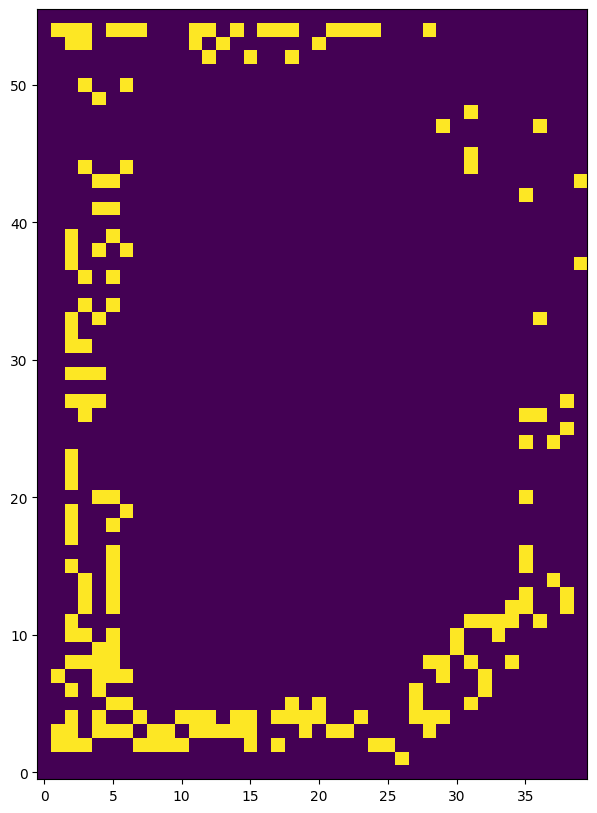

In [619]:
raw_im = cv.imread(img_path, 0)

im = cv.equalizeHist(raw_im)
im = np.fliplr(im)
print(im.shape)

# x_slice = slice(1730, 1730+40)
# y_slice = slice(125, 125+56)
x_slice = slice(1730, 1730+40)
y_slice = slice(853, 853+56)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(im[y_slice, x_slice])
ax.invert_yaxis()
plt.show()

56 40
max_val=0.2780669033527374
top_left=(1731, 854)
bottom_right=(1771, 910)


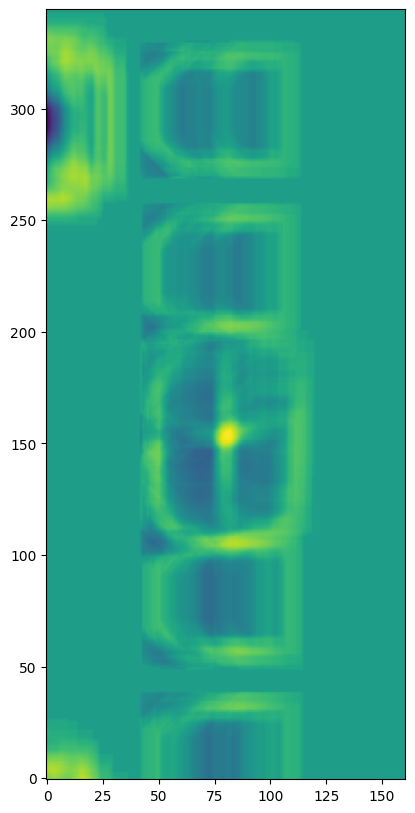

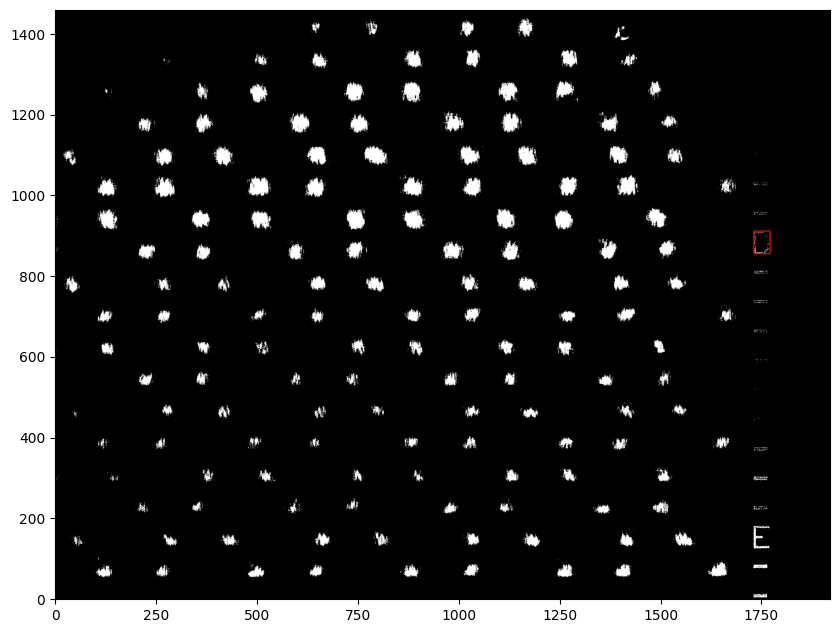

In [620]:
template_path = Path('../../ROI_Locator/Label_templates/IMECII/IMEC-II_2/D-Right.png')
template = cv.imread(template_path, 0)
template = cv.resize(template, (0, 0), fx=scale_factor[1], fy=scale_factor[0])

h, w = template.shape
print(h, w)

method = cv.TM_CCOEFF_NORMED

x_slice = slice(1650, 1850)
y_slice = slice(700, 1100)

res = cv.matchTemplate(im[y_slice, x_slice], template, method)
# res = cv.matchTemplate(im, template, method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

# Determine the top-left corner of the matched region
if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
    top_left = min_loc
else:
    top_left = max_loc

bottom_right = (top_left[0] + w, top_left[1] + h)


#  Correct for the slice
top_left = (top_left[0] + x_slice.start, top_left[1] + y_slice.start)
bottom_right = (bottom_right[0] + x_slice.start, bottom_right[1] + y_slice.start)
print(f'{max_val=}')
print(f'{top_left=}')
print(f'{bottom_right=}')

im_color = cv.cvtColor(im, cv.COLOR_GRAY2BGR)
cv.rectangle(im_color, top_left, bottom_right, (255, 0, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(res)
ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(im_color)
ax.invert_yaxis()
plt.show()

In [621]:
def find_label(target, scale_factor, params):
    template_path = params['template_path']

    template = cv.imread(template_path, 0)
    template = cv.resize(template, (0, 0), fx=scale_factor[1], fy=scale_factor[0])

    method = cv.TM_CCOEFF_NORMED

    x_slice = params['template_area']['x_slice']
    y_slice = params['template_area']['y_slice']

    res = cv.matchTemplate(target[y_slice, x_slice], template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    # Determine the bottom-left corner of the matched region
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        origin = min_loc
    else:
        origin = max_loc

    #  Correct for the slice
    origin = (origin[0] + x_slice.start,
              origin[1] + y_slice.start)
    return origin

In [622]:
def image_angle_from_horizontal(vector):
    """Calculates the angle of a 2D vector from the horizontal (x-axis) in degrees."""
    vector = np.array(vector)

    if len(vector) != 2:
        raise ValueError("Vector must be 2D.")

    x, y = vector[0], vector[1]
    angle_radians = np.arctan2(y, x)
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [623]:
def angle_between_vectors(vector1, vector2):
    """Calculates the angle between two vectors in degrees."""
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    if magnitude1 == 0 or magnitude2 == 0:
        # return not a number if a vector has zero magnitude.
        return float('nan')

    cosine_angle = dot_product / (magnitude1 * magnitude2)
    # clip to avoid domain errors.
    angle_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [624]:
def translate_vector(origin, vector):
    """Sets the origin of a vector to a new location."""
    vector = np.array(vector)
    origin = np.array(origin)

    return vector - origin

In [625]:
def scale_vector(vector, scale):
    """Scales a vector by a scalar value."""
    vector = np.array(vector)

    return vector * scale

In [648]:
def process_config_files(image_feature_path,
                         user_feature_list_path,
                         chip_map_path):

    image_feature_details = None
    feature_dict = None
    chip_map = None

    try:
        image_feature_details = pd.read_csv(image_feature_path)
    except FileNotFoundError:
        print(f'Error: File not found at {image_feature_path}')

    # Where the labels are according to the user (on the 'real' chip)
    try:
        with open(user_feature_list_path, 'r') as file:
            feature_dict = json.load(file)
    except FileNotFoundError:
        print(f'Error: File not found at {user_feature_list_path}')
    except json.JSONDecodeError:
        print(f'Error: Invalid JSON format in {user_feature_list_path}')

    # Where the labels are according to the chip GDSII file
    try:
        with open(chip_map_path, 'r') as file:
            chip_map = json.load(file)
    except FileNotFoundError:
        print(f'Error: File not found at {chip_map_path}')
    except json.JSONDecodeError:
        print(f'Error: Invalid JSON format in {chip_map_path}')

    # Filter chip map to only include the chip type we are interested in
    for c in chip_map["chip"]:
        if c["chip_type"] == feature_dict["chip_type"]:
            chip_map = c
            break

    return image_feature_details, feature_dict, chip_map

In [ ]:
def find_all_labels(target, feature_list_path, image_feature_path, 
                    chip_map_path, template_path, scale_factor, PLOT=False):

    image_feature_details, feature_dict, chip_map = process_config_files(
        image_feature_path, feature_list_path, chip_map_path)

    # Extract from chip map only the features we are interested in
    if chip_map["auto_locate_grating"]:
        chip_features = feature_dict.get("features", None)
        if not chip_features:
            raise ValueError('[ERROR] No features found in "FeatureLocation.json"')

    feature_labels = [f["label"].lower() for f in chip_features]
    chip_labels = [l for l in chip_map["labels"] if l["label"].lower() in feature_labels]

    # Update chip features with template path and area to search for the feature
    for idx, f in enumerate(chip_features):
        chip_features[idx]["template_path"] = Path(template_path, f'{f['label']}.png')
        if image_feature_details is not None:
            chip_features[idx]["template_area"] = {
                "x_slice": slice(f['feature_location'][0] - 100, f['feature_location'][0] + 100),
                "y_slice": slice(f['feature_location'][1] - 100, f['feature_location'][1] + 100),
            }
        else:
            mask = image_feature_details['Label'] == f['label']
            last_row = image_feature_details[mask].iloc[-1]
            chip_features[idx]["template_area"] = {
                "x_slice": slice(last_row['x'] - 100, last_row['x'] + 100),
                "y_slice": slice(last_row['y'] - 100, last_row['y'] + 100),
            }
    # print(f'{chip_labels=}')
    # print(f'{chip_features=}')

    if PLOT:
        im_color = cv.cvtColor(cv.equalizeHist(np.fliplr(raw_im)), cv.COLOR_GRAY2BGR)

    if image_feature_details is None:
        image_feature_details = pd.DataFrame(columns=['Image', 'Label', 'x', 'y', 'Timestamp'])
    locs = []
    image_name = r.file_path
    timestamp = r.time_stamp
    for f in chip_features:
        loc = find_label(target, scale_factor, f)
        new_data = {
            'Image': image_name,
            'Label': f["label"],
            'x': loc[0],
            'y': loc[1],
            'Timestamp': timestamp}
        new_row = pd.DataFrame([new_data])
        image_feature_details = pd.concat([image_feature_details, new_row],
                                          ignore_index=True)
        locs.append(loc)
        if PLOT:
            x, y = loc
            cv.rectangle(im_color, (x, y+5), (x+5, y), (255, 0, 0), 2)

    # print(image_feature_details.head())
    image_feature_details.to_csv(image_feature_path, index=False)

    # Calculate the distance between all combinations of chip map and chip feature labels
    loc_combinations = itertools.combinations(range(len(chip_labels)), 2)
    dist_chip_map = []
    dist_chip_feature = []
    for a, b in loc_combinations:
        dist_chip_map.append(translate_vector(chip_labels[a]["label_origin"], chip_labels[b]["label_origin"]))
        dist_chip_feature.append(translate_vector(locs[a], locs[b]))
    # print(f'{dist_chip_map=}')
    # print(f'{dist_chip_feature=}')

    # Cacluate average scaling factor using all combinations of chip map and chip feature distances
    scale_factor = np.round(np.linalg.norm(dist_chip_feature) / np.linalg.norm(dist_chip_map), 4)
    # print(f'Updated scale factor = {scale_factor}')

    # Calculate the angle between the chip map and chip feature labels separately
    chip_map_angle = image_angle_from_horizontal(translate_vector(chip_labels[0]["label_origin"], chip_labels[1]["label_origin"]))
    chip_feature_angle = image_angle_from_horizontal(translate_vector(locs[0], locs[1]))
    # print(f'{chip_map_angle=}')
    # print(f'{chip_feature_angle=}')

    # Calculate the angle of the image compared to the chip map
    # image can then be rotated by this angle to align with the chip map
    image_angle = np.round(chip_map_angle-chip_feature_angle, 0)
    # print(f'Image angle = {image_angle}')

    if PLOT:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(im_color)
        ax.invert_yaxis()
        plt.show()

    return scale_factor, image_angle

In [ ]:
def generate_ROI_file(image_feature_path,
                      user_feature_list_path,
                      chip_map_path,
                      ROI_path,
                      target_shape,
                      scale_factor,
                      image_angle):
    image_feature_details, _, chip_map = process_config_files(
            image_feature_path, user_feature_list_path, chip_map_path)

    # Filter chip map to only the gratings and their locations, sizes
    chip_gratings = chip_map.get("gratings", None)

    feature_labels = image_feature_details['Label'].unique()
    feature_labels = [l.lower() for l in feature_labels]
    chip_labels = [l for l in chip_map["labels"]
                if l["label"].lower() in feature_labels]

    locs = []
    for chip_label in chip_labels:
        mask = image_feature_details['Label'] == chip_label["label"]
        last_row = image_feature_details[mask].iloc[-1]
        locs.append((last_row['x'], last_row['y']))

    # Use 'translate_vector' to calculate translation vector to move the chip labels to the feature labels
    # Note: Chip labels location must be scaled before calculating the translation vector
    coord_offset = translate_vector(locs[0], scale_vector(
        chip_labels[0]["label_origin"], scale_factor))

    # Add translated grating location to chip grating dictionary
    for idx, g in enumerate(chip_gratings):
        chip_gratings[idx]["grating_origin"] = translate_vector(
            coord_offset, scale_vector(g["grating_origin"], scale_factor))

    # Create ROIs for each grating (North and South) using scaled grating sizes
    ROIs = {}
    for g in chip_gratings:
        x, y = g['grating_origin']
        x, y = int(x), int(y)
        if (x < 0 or
            y < 0 or
            x + int(g['x-size'] * scale_factor) > target_shape[1] or
            y + int(g['y-size'] * scale_factor) > target_shape[0]):
            continue
        grating_x_size = int(g['x-size'] * scale_factor)
        grating_y_size = int(g['y-size'] * scale_factor)
        ROIs[f"ROI_{g['label']}_N"] = {
            'label': f'{g['label']}_N',
            'flip': True,
            'coords': [x, y + grating_y_size//2],
            'size': [grating_x_size, grating_y_size//2],
        }
        ROIs[f"ROI_{g['label']}_S"] = {
            'label': f'{g['label']}_S',
            'flip': False,
            'coords': [x, y],
            'size': [grating_x_size, grating_y_size//2],
        }
    ROIs['image_angle'] = image_angle
    with open(ROI_path, 'w') as file:
        json.dump(ROIs, file, indent=4)

    return ROIs

In [ ]:
expt_path = Path(
    '/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206')
img_data_json_name = 'image_metadata_SU000001.json'

img_data = pd.read_json(Path(expt_path, img_data_json_name))
img_data = img_data.T.reset_index(drop=True)
img_data.columns = img_data.columns.str.replace(' ', '_').str.lower()
img_data['root_path'] = img_data['root_path'].str.replace('K:/', '')

# for r in img_data.itertuples():
#     print(f"Index: {r.Index}")
#     print(f"Experiment filepath: {r.root_path}")
#     print(f'Image filename: {r.file_path}')
#     print(
#         f'Image filepath: {Path('/Volumes/krauss', r.root_path, r.file_path)}')
#     # img_data.loc[r.Index, 'processed'] = True
#     break

img_path = Path('/Volumes/krauss', r.root_path, r.file_path)
im = cv.imread(img_path, 0)

target = np.fliplr(im)
target_shape = target.shape

user_feature_list_path = Path('FeatureLocation.json')
image_feature_path = Path('ImageFeatures.csv')
chip_map_path = Path('../../ROI_Locator/Label_templates/Chip_map.json')
template_path = Path('../../ROI_Locator/Label_templates/IMECII/IMEC-II_2')
ROI_path = Path('ROI_ChirpArray.json')
user_scale_factor = (0.75, 0.75)  # Template to image (i.e. template larger than image feature)

scale_factor, image_angle = find_all_labels(target,
                                            user_feature_list_path,
                                            image_feature_path,
                                            chip_map_path, template_path,
                                            user_scale_factor)

ROIs = generate_ROI_file(image_feature_path,
                         user_feature_list_path,
                         chip_map_path,
                         ROI_path,
                         target_shape,
                         scale_factor,
                         image_angle)

Index: 0
Experiment filepath: Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206
Image filename: img_000000000_Default_000.tif
Image filepath: /Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206/img_000000000_Default_000.tif
                           Image    Label     x    y  Timestamp
0  img_000000000_Default_000.tif  D-Right  1729  851          0
1  img_000000000_Default_000.tif  E-Right  1730  124          0
2  img_000000000_Default_000.tif  D-Right  1729  851          0
3  img_000000000_Default_000.tif  E-Right  1730  124          0
4  img_000000000_Default_000.tif  D-Right  1729  851  000000000
Updated scale factor = 0.727
Image angle = -0.0


img_000000050_Default_000.tif
(1460, 1920)
Error: File not found at ImageFeatures.csv


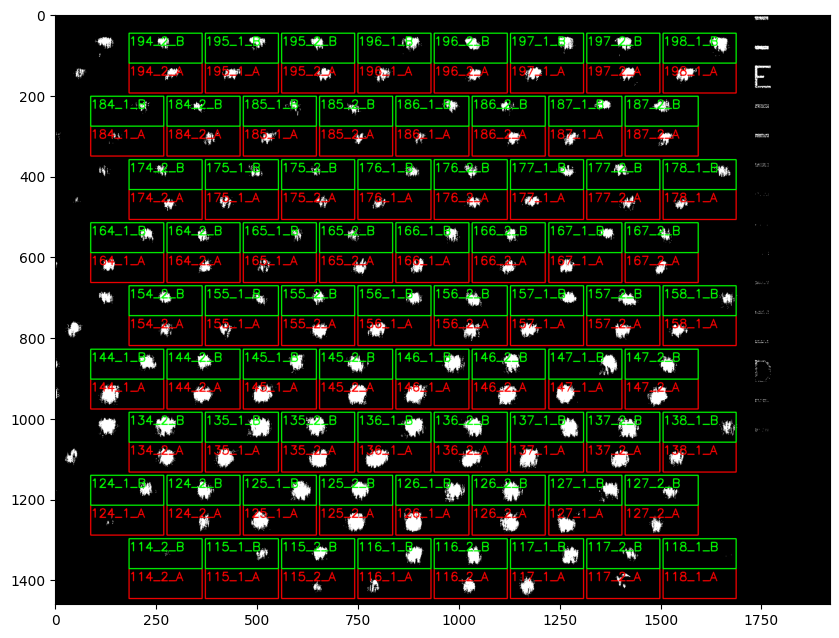

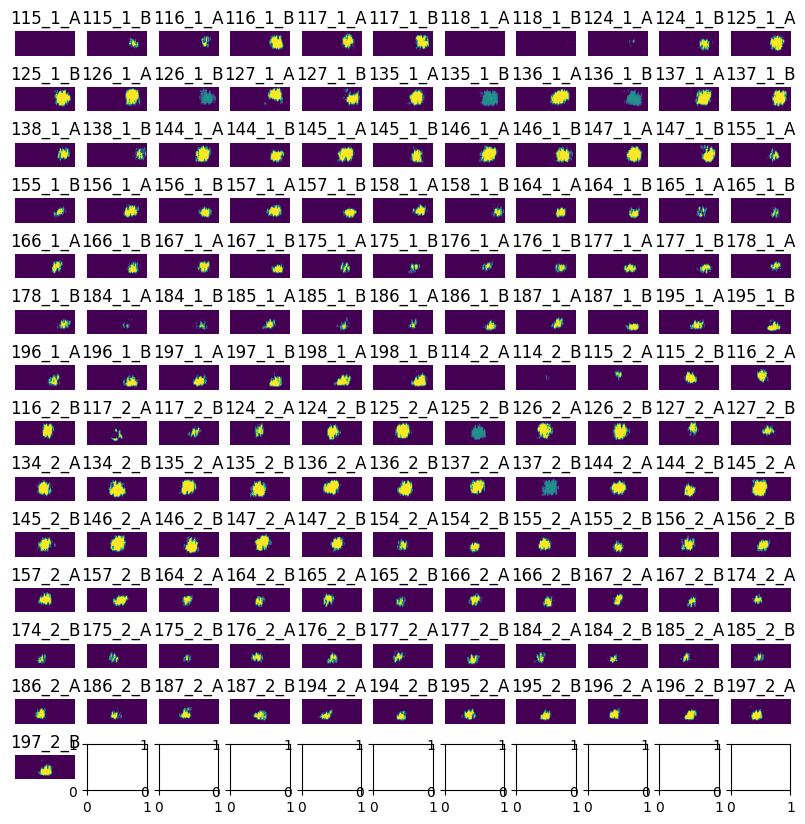

In [715]:
PLOT = True

image_num = 50
file_path = Path(f'img_{image_num:09d}_Default_000.tif')
root_path = Path('Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206')
img_path = Path('/Volumes/krauss', r.root_path, r.file_path)

print(file_path)

raw_im = cv.imread(img_path, 0)

im = cv.equalizeHist(raw_im)
im = np.fliplr(im)
print(im.shape)

_, _, chip_map = process_config_files(image_feature_path,
                                      user_feature_list_path,
                                      chip_map_path)

# Filter chip map to only the gratings and their locations, sizes
chip_gratings = chip_map.get("gratings", None)

ROI_path = Path('ROI_ChirpArray.json')
with open(ROI_path, 'r') as file:
    ROIs = json.load(file)

# Extract data from each ROI (using mean and argmax - simple for now)
line_data_A = []
line_data_B = []
for k, v in ROIs.items():
    if k == 'image_angle':
        continue
    x_slice = slice(v['coords'][0], v['coords'][0] + v['size'][0])
    y_slice = slice(v['coords'][1], v['coords'][1] + v['size'][1])
    data = target[y_slice, x_slice]
    if v['flip']:
        data = np.fliplr(data)
    if 'A' in v['label']:
        line_data_A.append(np.mean(data, axis=0))
    else:
        line_data_B.append(np.mean(data, axis=0))

if PLOT:
    # Display grating locations on the image for visual confirmation
    im_color = cv.cvtColor(cv.equalizeHist(im), cv.COLOR_GRAY2BGR)
    for k, v in ROIs.items():
        if k == 'image_angle':
            continue
        x, y = v['coords']
        x_size, y_size = v['size']
        color = (255, 0, 0)
        if 'B' in v['label']:
            color = (0, 255, 0)
        cv.rectangle(im_color, (x, y + y_size), (x + x_size, y), color, 2)
        cv.putText(im_color, v['label'], (x, y + 30),
                    cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(im_color)
    # ax.invert_yaxis()
    plt.show()

    # Display ROIs on the image for visual confirmation
    fig, ax = plt.subplots(14, 11, figsize=(10, 10))
    a = ax.ravel()
    count = 0
    for k, v in ROIs.items():
        if k == 'image_angle':
            continue
        x_slice = slice(v['coords'][0], v['coords'][0] + v['size'][0])
        y_slice = slice(v['coords'][1], v['coords'][1] + v['size'][1])
        data = target[y_slice, x_slice]
        if v['flip']:
            data = np.fliplr(data)
        try:
            a[count].imshow(data)
            a[count].set_title(v['label'])
            a[count].invert_yaxis()
            a[count].axis('off')
            count += 1
        except:
            pass
    plt.show()

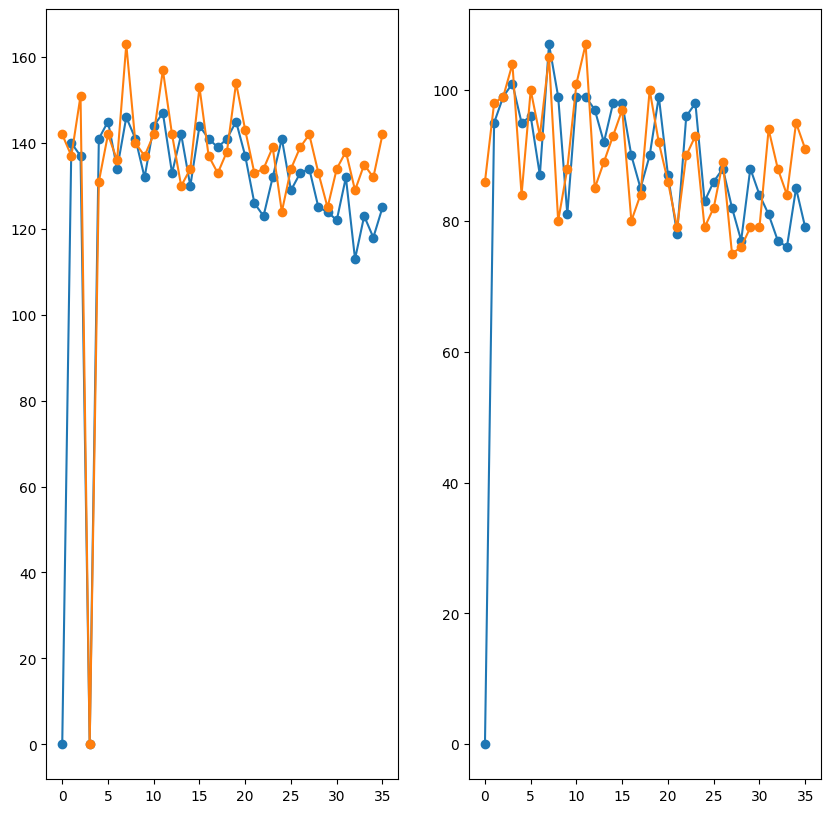

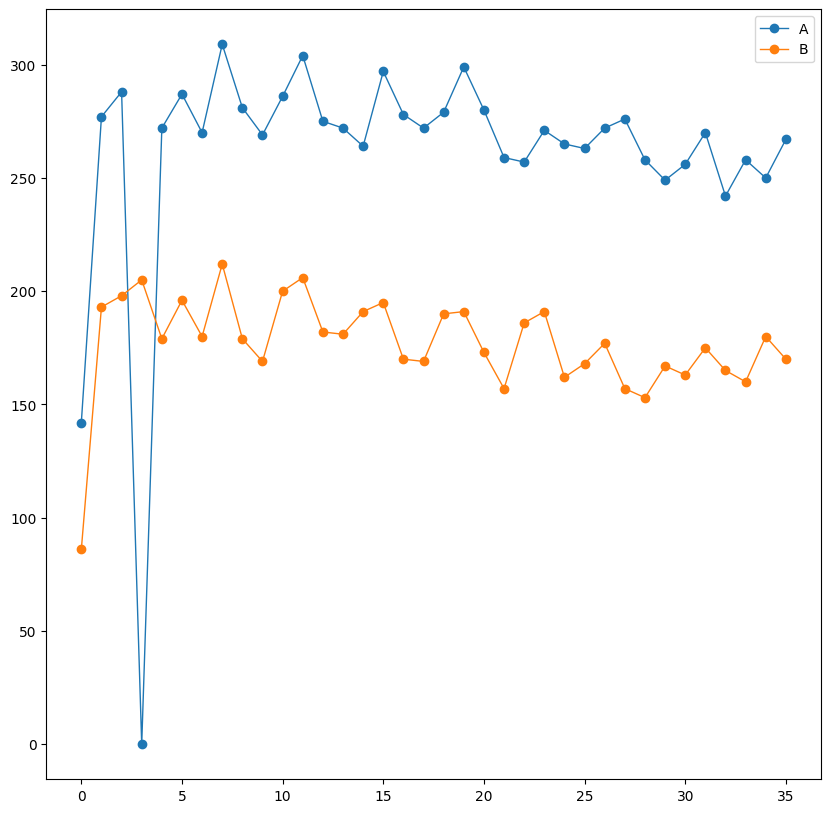

In [673]:
max_data_A = np.argmax(line_data_A, axis=1)
max_data_B = np.argmax(line_data_B, axis=1)

if PLOT:
    # Display argmax data from each ROI, split into A and B and 
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax.ravel()[0].plot(max_data_A[::2], marker='o')
    ax.ravel()[0].plot(max_data_A[1::2], marker='o')
    ax.ravel()[1].plot(max_data_B[::2], marker='o')
    ax.ravel()[1].plot(max_data_B[1::2], marker='o')
    plt.show()

    # Display bar separation (i.e. combined argmax data) from each ROI for A and B
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(max_data_A[::2] + max_data_A[1::2], marker='o', linewidth=1, label='A')
    ax.plot(max_data_B[::2] + max_data_B[1::2], marker='o', linewidth=1, label='B')
    ax.legend()
    plt.show()

In [ ]:
expt_path = Path(
    '/Volumes/krauss/Lisa/GMR/Array/250206/Experiment_1_ethanol/loc1_1/20250206')
img_data_json_name = 'image_metadata_SU000001.json'

img_data = pd.read_json(Path(expt_path, img_data_json_name))
img_data = img_data.T.reset_index(drop=True)
img_data.columns = img_data.columns.str.replace(' ', '_').str.lower()
img_data['root_path'] = img_data['root_path'].str.replace('K:/', '')

user_feature_list_path = Path('FeatureLocation.json')
image_feature_path = Path('ImageFeatures.csv')
chip_map_path = Path('../../ROI_Locator/Label_templates/Chip_map.json')
template_path = Path('../../ROI_Locator/Label_templates/IMECII/IMEC-II_2')
ROI_path = Path('ROI_ChirpArray.json')
# Scale factor for template to image (i.e. template larger than image feature)
user_scale_factor = (0.75, 0.75)

for r in img_data.itertuples():
    print(f'Index: {r.Index} \t Image filename: {r.file_path}')
    # img_data.loc[r.Index, 'processed'] = True

    img_path = Path('/Volumes/krauss', r.root_path, r.file_path)
    im = cv.imread(img_path, 0)

    target = np.fliplr(im)
    target_shape = target.shape

    scale_factor, image_angle = find_all_labels(target,
                                                user_feature_list_path,
                                                image_feature_path,
                                                chip_map_path, template_path,
                                                user_scale_factor)
    break

Index: 0 	 Image filename: img_000000000_Default_000.tif
Index: 1 	 Image filename: img_000000001_Default_000.tif
Index: 2 	 Image filename: img_000000002_Default_000.tif
Index: 3 	 Image filename: img_000000003_Default_000.tif
Index: 4 	 Image filename: img_000000004_Default_000.tif
Index: 5 	 Image filename: img_000000005_Default_000.tif
Index: 6 	 Image filename: img_000000006_Default_000.tif
Index: 7 	 Image filename: img_000000007_Default_000.tif
Index: 8 	 Image filename: img_000000008_Default_000.tif
Index: 9 	 Image filename: img_000000009_Default_000.tif
Index: 10 	 Image filename: img_000000010_Default_000.tif
Index: 11 	 Image filename: img_000000011_Default_000.tif
Index: 12 	 Image filename: img_000000012_Default_000.tif
Index: 13 	 Image filename: img_000000013_Default_000.tif
Index: 14 	 Image filename: img_000000014_Default_000.tif
Index: 15 	 Image filename: img_000000015_Default_000.tif
Index: 16 	 Image filename: img_000000016_Default_000.tif
Index: 17 	 Image filena

                           Image    Label     x    y  Timestamp
0  img_000000000_Default_000.tif  D-Right  1729  851          0
1  img_000000000_Default_000.tif  E-Right  1730  124          0
2  img_000000001_Default_000.tif  D-Right  1729  851          1
3  img_000000001_Default_000.tif  E-Right  1730  124          1
4  img_000000002_Default_000.tif  D-Right  1729  851          2


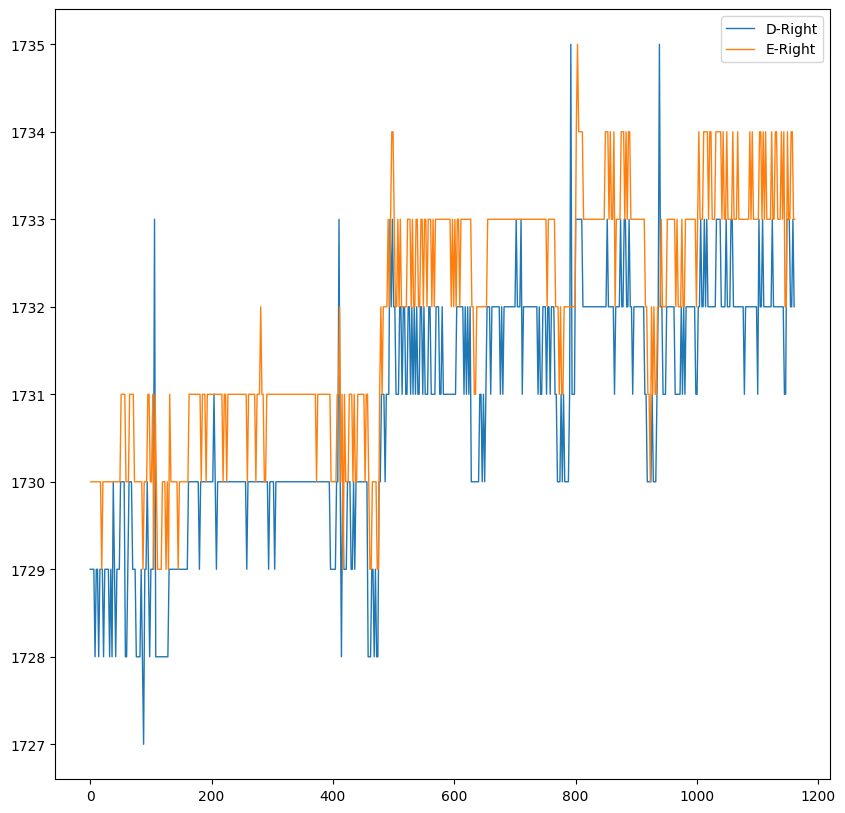

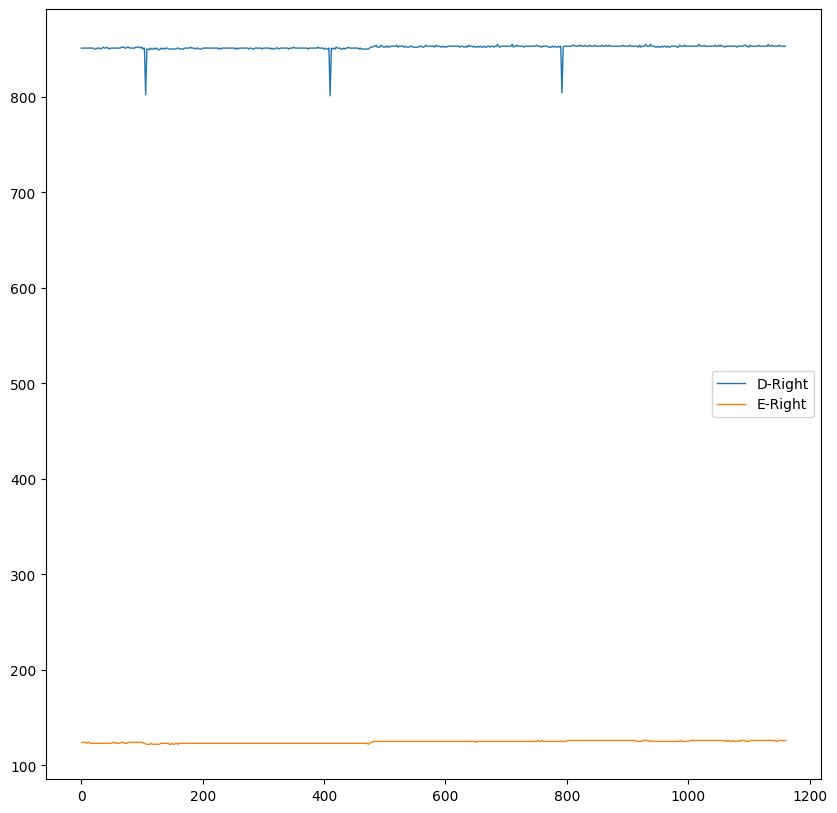

In [ ]:
data = pd.read_csv('ImageFeatures_Lisa.csv')
print(data.head())

# d_right = data[data['Label'] == 'D-Right']
# e_right = data[data['Label'] == 'E-Right']
# d_right.to_csv(Path(expt_path, 'Sample_Drift_D-Right.csv'), index=False)
# e_right.to_csv(Path(expt_path, 'Sample_Drift_E-Right.csv'), index=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(data[data['Label'] == 'D-Right']['x'], marker='', linewidth=1, label='D-Right')
ax.plot(data[data['Label'] == 'E-Right']['x'], marker='', linewidth=1, label='E-Right')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(data[data['Label'] == 'D-Right']['y'], marker='', linewidth=1, label='D-Right')
ax.plot(data[data['Label'] == 'E-Right']['y'], marker='', linewidth=1, label='E-Right')
ax.legend()
plt.show()